In [1]:
##get the first frame of the project video

import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip, concatenate_videoclips
from IPython.display import HTML
import matplotlib.image as mpimg

clip1 = VideoFileClip("project_video.mp4")
video_duration = clip1.duration
clip1.save_frame("project_video_1st_frame.jpeg")
image = mpimg.imread('project_video_1st_frame.jpeg')


print("Duration:", video_duration)
print("image height:", image.shape[0])
print("image width:", image.shape[1])


Duration: 50.4
image height: 720
image width: 1280


In [2]:


clip_sub1 = clip1.subclip(0, 9.04)
clip_sub2 = clip1.subclip(9, 18.04)
clip_sub3 = clip1.subclip(18, 27.04)
clip_sub4 = clip1.subclip(27, 36.04)
clip_sub5 = clip1.subclip(36, 45.04)
clip_sub6 = clip1.subclip(45, video_duration+0.04)



clip_sub1.write_videofile("video_1.mp4", fps=None, audio=False)
clip_sub2.write_videofile("video_2.mp4", fps=None, audio=False)
clip_sub3.write_videofile("video_3.mp4", fps=None, audio=False)
clip_sub4.write_videofile("video_4.mp4", fps=None, audio=False)
clip_sub5.write_videofile("video_5.mp4", fps=None, audio=False)
clip_sub6.write_videofile("video_6.mp4", fps=None, audio=False)





[MoviePy] >>>> Building video video_1.mp4
[MoviePy] Writing video video_1.mp4


100%|██████████| 226/226 [00:10<00:00, 22.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_1.mp4 

[MoviePy] >>>> Building video video_2.mp4
[MoviePy] Writing video video_2.mp4


100%|██████████| 226/226 [00:09<00:00, 23.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_2.mp4 

[MoviePy] >>>> Building video video_3.mp4
[MoviePy] Writing video video_3.mp4


100%|██████████| 226/226 [00:10<00:00, 21.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_3.mp4 

[MoviePy] >>>> Building video video_4.mp4
[MoviePy] Writing video video_4.mp4


100%|██████████| 226/226 [00:09<00:00, 23.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_4.mp4 

[MoviePy] >>>> Building video video_5.mp4
[MoviePy] Writing video video_5.mp4


100%|██████████| 226/226 [00:11<00:00, 16.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_5.mp4 

[MoviePy] >>>> Building video video_6.mp4
[MoviePy] Writing video video_6.mp4


100%|██████████| 136/136 [00:05<00:00, 25.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_6.mp4 



In [3]:
##use calibration images to calculate the distortion of the camera


import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)



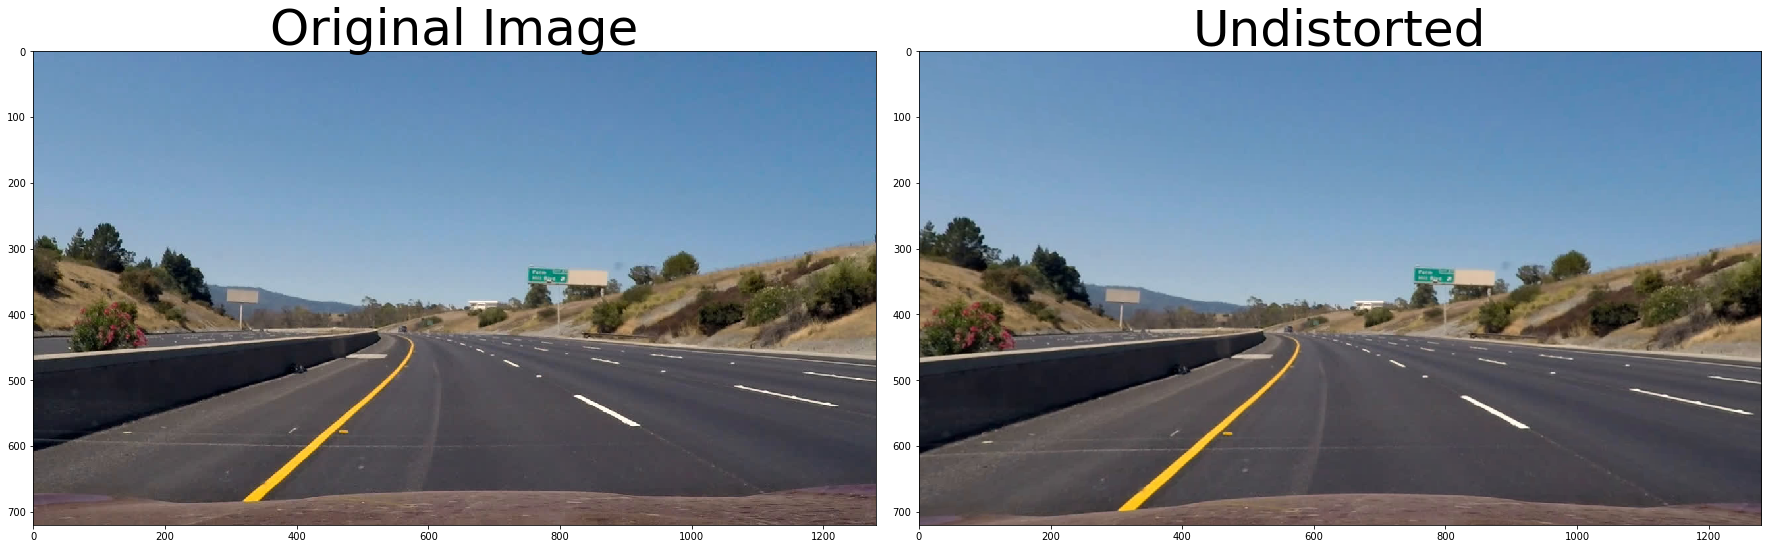

In [4]:
##using the objpoints and imgpoints obtained above to define the undistort function


ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (1280,720),None,None)


image_dst = cv2.undistort(image, mtx, dist, None, mtx)


##undistort the first frame

cv2.imwrite('project_video_1st_frame_undst.jpg',image_dst)

%matplotlib inline

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(image_dst)
ax2.set_title('Undistorted', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

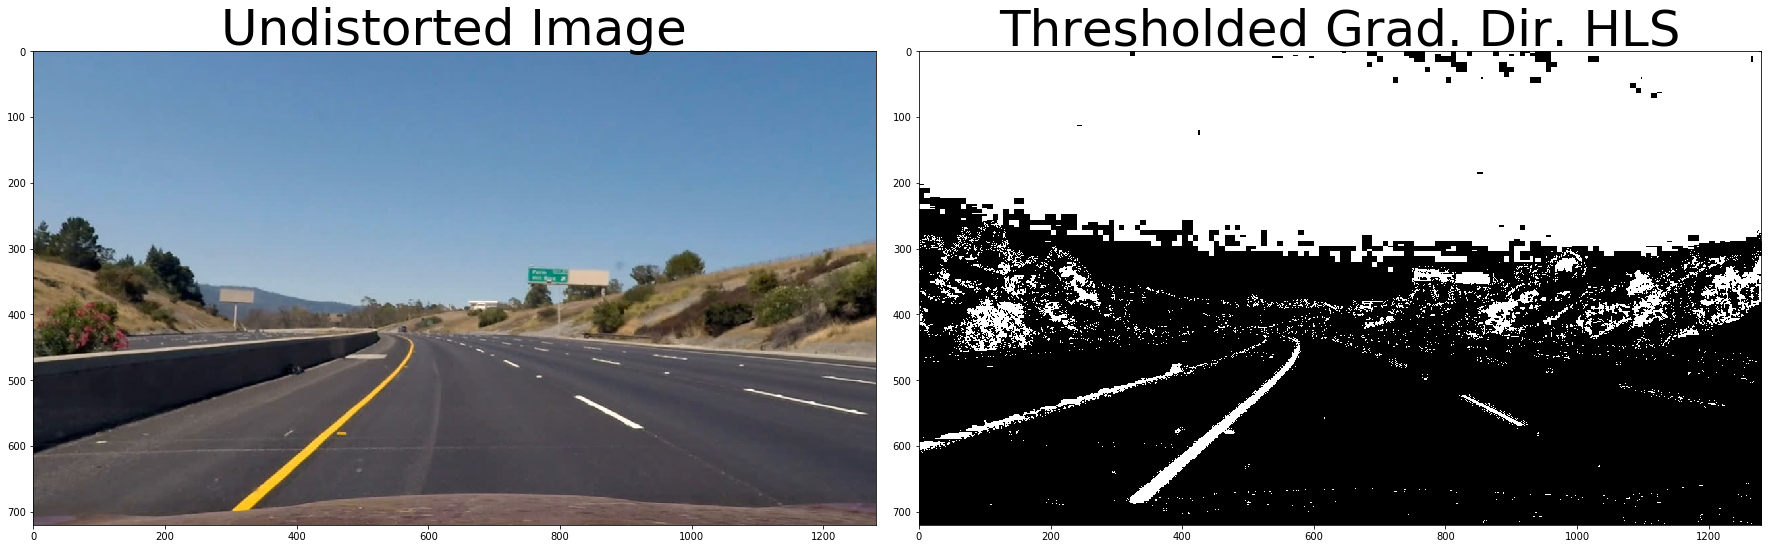

In [5]:
##define the gradient functions 


%matplotlib inline


def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    binary_output = sxbinary # Remove this line
    return binary_output # Calculate directional gradient

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    abs_sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    angle = np.arctan(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(angle)
    binary_output[(angle > thresh[0]) & (angle < thresh[1])] = 1
    return binary_output


def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

##apply the combined gradient thresholds to the first frame of the video

def combining(img):
    ksize = 15 
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
    hls_binary = hls_select(image, thresh = (90, 255))  
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))|(hls_binary ==1)] = 1
    return combined_binary

combined = combining(image_dst)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_dst)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Dir. HLS', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



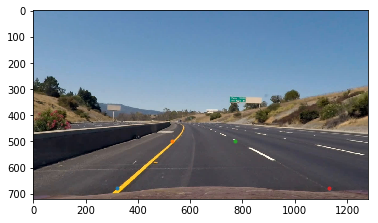

In [6]:
##manually find 4 points, for perspective transformation
plt.imshow(image_dst)
plt.plot(320, 680, '.')
plt.plot(530, 500, '.')
plt.plot(770, 500, '.')
plt.plot(1130, 680, '.')

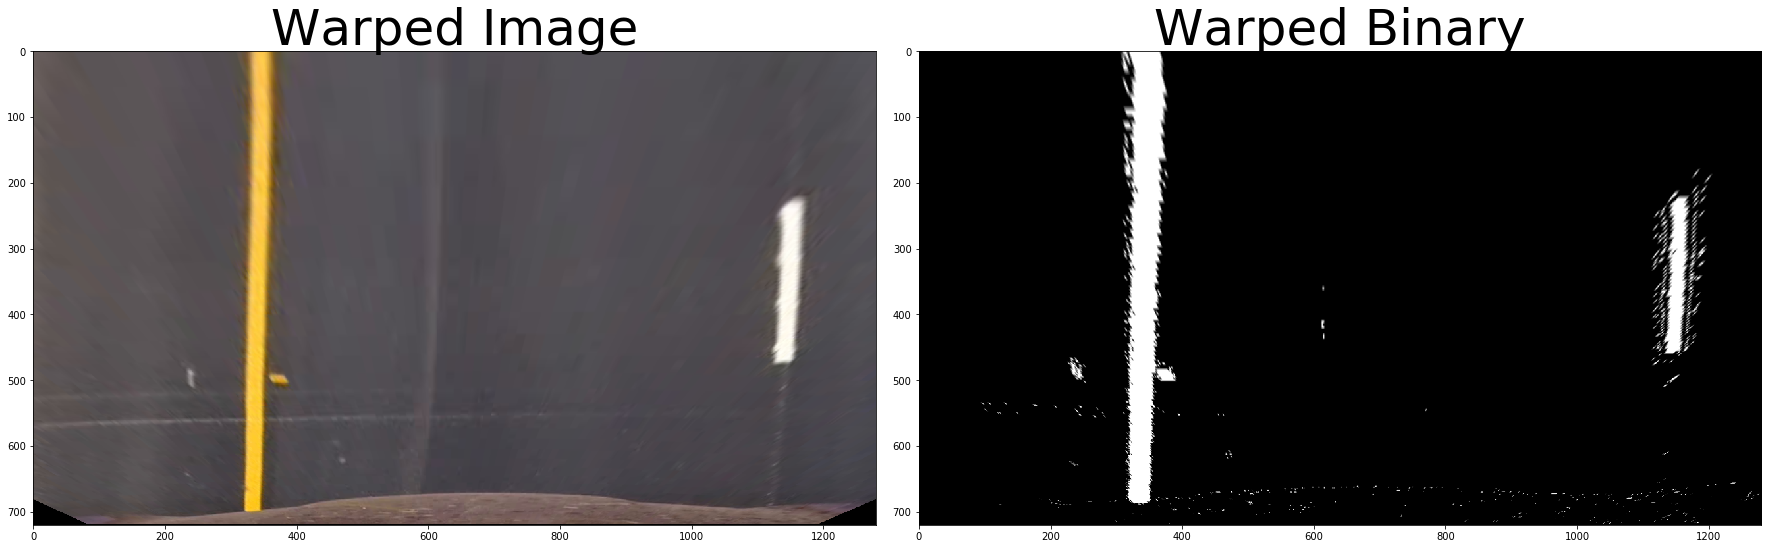

In [7]:
##using the 4 points found in the original image, and transform the lanes into bird's eye perspective.
def image_warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[320, 680],[530, 500],[770, 500],[1130, 680]])
    dst = np.float32([[320, 680],[320, 0],[1130, 0],[1130, 680]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped= cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

warped_image, M1, Minv1 = image_warp(image_dst)
binary_warped, M2, Minv2 = image_warp(combined)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(warped_image)
ax1.set_title('Warped Image', fontsize=50)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped Binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



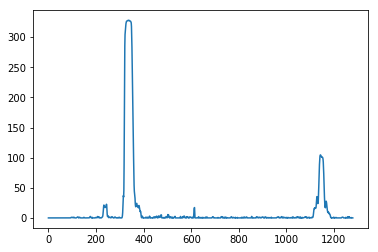

In [8]:
##plot the histogram of the lower half of the warped binary image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

[-1.3556684476620204e-05, -0.0068054925195287367, 343.49076621280335]
[5.2599313341922717e-05, -0.11506967166465519, 1184.1153232198924]
[ 343.49076621  343.48394716  343.477101    343.47022773  343.46332734]
[ 1184.11532322  1184.00030615  1183.88539427  1183.7705876   1183.65588612]


(720, 0)

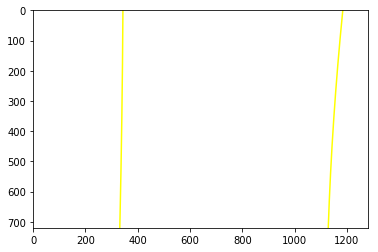

In [9]:
#fit_polynomial_raw takes in an image, and finds the left_fit and right_fit values.


def fit_polynomial_raw(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#    return(left_fitx, right_fitx, left_fit, right_fit, ploty)
    return(left_fit, right_fit,left_fitx, right_fitx, ploty)

#find the left_fit and right_fit of the first image

#left_fitx, right_fitx, left_fit, right_fit, ploty = fit_polynomial_raw(binary_warped)
left_fit, right_fit, left_fitx, right_fitx, ploty= fit_polynomial_raw(binary_warped)


print(list(left_fit))

print(list(right_fit))
    
print(left_fitx[0:5])
print(right_fitx[0:5])


plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

plt.xlim(0, 1280)
plt.ylim(720, 0)

In [10]:
clip_sub1.save_frame("frame_1.jpeg")
image1 = mpimg.imread('frame_1.jpeg')

clip_sub2.save_frame("frame_2.jpeg")
image2 = mpimg.imread('frame_2.jpeg')

clip_sub3.save_frame("frame_3.jpeg")
image3 = mpimg.imread('frame_3.jpeg')

clip_sub4.save_frame("frame_4.jpeg")
image4 = mpimg.imread('frame_4.jpeg')

clip_sub5.save_frame("frame_5.jpeg")
image5 = mpimg.imread('frame_5.jpeg')

clip_sub6.save_frame("frame_6.jpeg")
image6 = mpimg.imread('frame_6.jpeg')



In [11]:
class Line():
    def __init__(self):
        self.lf = []
        self.rf = []
        self.lfx = []
        self.rfx = []
        self.pl = []
        self.lcurve = None
        self.rcurve = None

In [12]:
line = Line()

line.lfx = left_fitx
line.rfx = right_fitx

def curve(left_fitx, right_fitx,ploty):
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return(left_curverad, right_curverad)

print(curve(line.lfx, line.rfx,ploty))


(12114.279791297009, 3122.3390627292379)


In [13]:

def project_lines(warped, image_dst, left_fitx, right_fitx, ploty):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([line.lfx, line.pl]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([line.rfx, line.pl])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    newwarp = cv2.warpPerspective(color_warp, Minv1, (image_dst.shape[1], image_dst.shape[0])) 
    
    projected = cv2.addWeighted(image_dst, 1, newwarp, 0.3, 0)
    return(projected)

720 720
[ -1.35566845e-05  -6.80549252e-03   3.43490766e+02]
[  5.25993133e-05  -1.15069672e-01   1.18411532e+03]
12114.2797913
3122.33906273


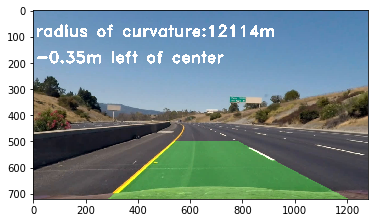

In [14]:

        
def image_processing(image):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (image.shape[1], image.shape[0]),None,None)
    image_dst = cv2.undistort(image, mtx, dist, None, mtx)
    combined = combining(image_dst)
    binary_warped, M, Minv = image_warp(combined)
    line.lf, line.rf, line.lfx, line.rfx, line.pl = fit_polynomial_raw(binary_warped)
    

    line.lcurve, line.rcurve = curve(line.lfx, line.rfx,ploty)
    print(len(line.lfx), len(line.rfx))
    
    text1 = "radius of curvature:" + str(int(line.lcurve)) + "m"
    
    projected_image = project_lines(binary_warped, image_dst, line.lfx, line.rfx, line.pl)
    text1_image =cv2.putText(img=np.copy(projected_image), text=text1, org=(10,100),fontFace=2, fontScale=2, color=(255,255,255), thickness=5)
    text2 = str(round((640 - (line.lfx[700] + line.rfx[700])//2) * 2.7/700, 2)) + "m left of center"
    text_image =cv2.putText(img=np.copy(text1_image), text=text2, org=(10,200),fontFace=2, fontScale=2, color=(255,255,255), thickness=5)
    return(text_image)

projected_image= image_processing(image)
plt.imshow(projected_image)

print(line.lf) 
print(line.rf)
print(line.lcurve)
print(line.rcurve)


In [16]:
import cv2
vidcap = cv2.VideoCapture('video_1.mp4')
success,image = vidcap.read()
count = 10000
success = True
while success:
    success,image = vidcap.read()
    cv2.imwrite("frame1/frame%d.jpg" % count, image)
    count += 1
print("frames saved")
  

frames saved


In [17]:
import cv2
vidcap = cv2.VideoCapture('video_2.mp4')
success,image = vidcap.read()
count = 20000
success = True
while success:
    success,image = vidcap.read()
    cv2.imwrite("frame2/frame%d.jpg" % count, image)
    count += 1
print("frames saved")
  

frames saved


In [ ]:
import cv2
vidcap = cv2.VideoCapture('video_3.mp4')
success,image = vidcap.read()
count = 30000
success = True
while success:
    success,image = vidcap.read()
    cv2.imwrite("frame3/frame%d.jpg" % count, image)
    count += 1
print("frames saved")
  

frames saved


In [ ]:
import cv2
vidcap = cv2.VideoCapture('video_4.mp4')
success,image = vidcap.read()
count = 40000
success = True
while success:
    success,image = vidcap.read()
    cv2.imwrite("frame4/frame%d.jpg" % count, image)
    count += 1
print("frames saved")
  

In [ ]:
import cv2
vidcap = cv2.VideoCapture('video_5.mp4')
success,image = vidcap.read()
count = 50000
success = True
while success:
    success,image = vidcap.read()
    cv2.imwrite("frame5/frame%d.jpg" % count, image)
    count += 1
print("frames saved")
  

In [ ]:
import cv2
vidcap = cv2.VideoCapture('video_6.mp4')
success,image = vidcap.read()
count = 60000
success = True
while success:
    success,image = vidcap.read()
    cv2.imwrite("frame6/frame%d.jpg" % count, image)
    count += 1
print("frames saved")
  

In [ ]:
import numpy
import os
from scipy import ndimage, misc
import re
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

test_images = []
file_names= []
for root, dirnames, filenames in os.walk("frame1"):
    for filename in filenames:
        if re.search("\.(jpg)$", filename):
            filepath = os.path.join(root, filename)
            image = ndimage.imread(filepath, mode="RGB")
            test_images.append(image)
            file_names.append(filename)




In [ ]:
projected = []
for image in test_images:
    projected_image= image_processing(image)
    projected.append(projected_image)
    print(len(projected))


In [ ]:
from PIL import Image
fileNamePrefix = "out1/out_"
fileNameSuffix = ".jpg"



for idx, imageContent in enumerate(projected):
    fileName = fileNamePrefix + str(idx+10000) + fileNameSuffix
    im = Image.fromarray(imageContent)
    im.save(fileName)
    print(idx)

In [ ]:
test_images = []
file_names= []
for root, dirnames, filenames in os.walk("frame2"):
    for filename in filenames:
        if re.search("\.(jpg)$", filename):
            filepath = os.path.join(root, filename)
            image = ndimage.imread(filepath, mode="RGB")
            test_images.append(image)
            file_names.append(filename)

projected = []
for image in test_images:
    projected_image= image_processing(image)
    projected.append(projected_image)
    print(len(projected))

fileNamePrefix = "out2/out_"
fileNameSuffix = ".jpg"



for idx, imageContent in enumerate(projected):
    fileName = fileNamePrefix + str(idx+20000) + fileNameSuffix
    im = Image.fromarray(imageContent)
    im.save(fileName)
    print(idx)

In [ ]:
test_images = []
file_names= []
for root, dirnames, filenames in os.walk("frame3"):
    for filename in filenames:
        if re.search("\.(jpg)$", filename):
            filepath = os.path.join(root, filename)
            image = ndimage.imread(filepath, mode="RGB")
            test_images.append(image)
            file_names.append(filename)

projected = []
for image in test_images:
    projected_image= image_processing(image)
    projected.append(projected_image)
    print(len(projected))

fileNamePrefix = "out3/out_"
fileNameSuffix = ".jpg"



for idx, imageContent in enumerate(projected):
    fileName = fileNamePrefix + str(idx+30000) + fileNameSuffix
    im = Image.fromarray(imageContent)
    im.save(fileName)
    print(idx)

In [ ]:
test_images = []
file_names= []
for root, dirnames, filenames in os.walk("frame4"):
    for filename in filenames:
        if re.search("\.(jpg)$", filename):
            filepath = os.path.join(root, filename)
            image = ndimage.imread(filepath, mode="RGB")
            test_images.append(image)
            file_names.append(filename)

projected = []
for image in test_images:
    projected_image= image_processing(image)
    projected.append(projected_image)
    print(len(projected))

fileNamePrefix = "out4/out_"
fileNameSuffix = ".jpg"



for idx, imageContent in enumerate(projected):
    fileName = fileNamePrefix + str(idx+40000) + fileNameSuffix
    im = Image.fromarray(imageContent)
    im.save(fileName)
    print(idx)

In [ ]:
test_images = []
file_names= []
for root, dirnames, filenames in os.walk("frame5"):
    for filename in filenames:
        if re.search("\.(jpg)$", filename):
            filepath = os.path.join(root, filename)
            image = ndimage.imread(filepath, mode="RGB")
            test_images.append(image)
            file_names.append(filename)

projected = []
for image in test_images:
    projected_image= image_processing(image)
    projected.append(projected_image)
    print(len(projected))

fileNamePrefix = "out5/out_"
fileNameSuffix = ".jpg"



for idx, imageContent in enumerate(projected):
    fileName = fileNamePrefix + str(idx+50000) + fileNameSuffix
    im = Image.fromarray(imageContent)
    im.save(fileName)
    print(idx)

In [ ]:
test_images = []
file_names= []
for root, dirnames, filenames in os.walk("frame6"):
    for filename in filenames:
        if re.search("\.(jpg)$", filename):
            filepath = os.path.join(root, filename)
            image = ndimage.imread(filepath, mode="RGB")
            test_images.append(image)
            file_names.append(filename)

projected = []
for image in test_images:
    projected_image= image_processing(image)
    projected.append(projected_image)
    print(len(projected))

fileNamePrefix = "out6/out_"
fileNameSuffix = ".jpg"



for idx, imageContent in enumerate(projected):
    fileName = fileNamePrefix + str(idx+60000) + fileNameSuffix
    im = Image.fromarray(imageContent)
    im.save(fileName)
    print(idx)

In [ ]:
out_clip_1 = VideoFileClip("out1.mp4")
out_clip_2 = VideoFileClip("out2.mp4")
out_clip_3 = VideoFileClip("out3.mp4")
out_clip_4 = VideoFileClip("out4.mp4")
out_clip_5 = VideoFileClip("out5.mp4")
out_clip_6 = VideoFileClip("out6.mp4")

final_clip = concatenate_videoclips([out_clip_1, out_clip_2, out_clip_3,out_clip_4, out_clip_5,out_clip_6])


In [ ]:
final_clip.write_videofile("final_output.mp4", fps=None, audio=False)